In [1]:
import re
import numpy as np
from nltk.corpus import stopwords 

# clean up given string
def clean_text(raw): 
    # Remove link
    raw = re.sub(r'http\S+', '', raw)
    # Remove unexpected artifacts
    raw = re.sub(r'â€¦', '', raw)
    raw = re.sub(r'…', '', raw)
    raw = re.sub(r'â€™', "'", raw)
    raw = re.sub(r'â€˜', "'", raw)
    raw = re.sub(r'\$q\$', "'", raw)
    raw = re.sub(r'&amp;', "and", raw)
    # remove non valid characters
    raw = re.sub('[^A-Za-z0-9#@ ]+', "", raw)
    words = raw.split()  

    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    return( " ".join(words))

# create onehot representation of the label
def get_onehot(arr, num_class):
    return np.eye(num_class)[np.array(arr).reshape(-1)]

In [ ]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

import time
import datetime
import json

# twitter api keys
consumer_key = 'ckey'
consumer_secret = 'csecret'
access_token = 'atok'
access_token_secret = 'atoksecret'

# given a list of keywords and a tweet in string format, check if any keywords exist in the tweet
def check_keywords(keywords,tweet_str):
    t = False
    for astr in keywords:
        for x in astr.split():
            if x.lower() in tweet_str.lower():
                t = True
            else:
                t = False
                break
        if t == True:
            break
    return t

# load the tab seperated dictionary of query keywords
def load_qdict(file_path):
    qdict = dict()
    #Open the file
    with open(file_path,'r') as inf:
        for line in inf:
            sline = line.split('\t')
            if len(sline) > 2 or len(sline) < 2:
                continue
            if sline[1] not in qdict:
                qdict[sline[1]] = list()
                qdict[sline[1]].append(sline[0])
            else:
                qdict[sline[1]].append(sline[0])

    if not qdict:
        print("Dictionary of queries is empty.")
        exit()
    return qdict

# listener class for tweepy Stream
class JsonListener(StreamListener):
    """ A listener handles tweets that are received from the stream.
    This is a basic listener that just prints received tweets to stdout.
    """
    def on_data(self, data):
        try:
            dat = json.loads(data)
            if "extended_tweet" in dat:
                dat["extended_tweet"]["full_text"] = dat["extended_tweet"]["full_text"].replace("\"","$q$")
            else:
                dat['text'] = dat['text'].replace("\"","$q$")

            date = '_'.join([ dat['created_at'].split(' ')[i] for i in [1,2,5] ])

            # save tweet
            with open('data_'+date+'.txt', 'a') as file:
                json.dump(dat,file)
            for qk in qdict:
                queries = []
                for el in qdict[qk]:
                    queries.append(el)

                # save type
                if check_keywords(queries,data):
                    tmp_json = {'tweetid':dat['id'], 'date': date}
                    with open('stock_'+qk[:-1]+'.txt', 'a') as file:
                        json.dump(tmp_json,file)
        except BaseException as e:
            print('Failed on_data() ', str(e))
            print(dat)
            outf=open("error_log.txt","a")
            outf.write(str(datetime.datetime.now().isoformat())+"\t"+str(status)+"\n")
            outf.close()
            time.sleep(910)        

    def on_error(self, status):
        print('On Error! '+str(status))
        outf=open("error_log.txt","a")
        outf.write(str(datetime.datetime.now().isoformat())+"\t"+str(status)+"\n")
        outf.close()

        #if we have exceeded our rate limit
        if status == 420 or status == 429:
            #Wait 15 minutes before attempting to reconnect
            print("Rate Limit Exceeded.  Sleeping for 15 minutes.")
            time.sleep(901)
            return False

if __name__ == "__main__":
    qdict = load_qdict('my_queries.txt')
    queries = []
    for qk in qdict:
        for el in qdict[qk]:
            queries.append(el)
    print(queries)


    l = JsonListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l,tweet_mode='extended')
    stream.filter(track=queries)

['climate change', 'global warming', 'warming planet']
On Error! 401
On Error! 401
On Error! 401
On Error! 401
On Error! 401
On Error! 401


In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
Corpus = pd.read_csv("twitter_sentiment_data.csv")
Corpus.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [3]:
Corpus.describe(include='all')

,sentiment,message,tweetid
count,43943.000000,43943,4.394300e+04
unique,NaN,41033,NaN
top,NaN,RT @StephenSchlegel: she's thinking about how ...,NaN
freq,NaN,506,NaN
mean,0.853924,NaN,8.367966e+17
std,0.853543,NaN,8.568506e+16
min,-1.000000,NaN,5.926334e+17
25%,0.000000,NaN,7.970376e+17
50%,1.000000,NaN,8.402301e+17
75%,1.000000,NaN,9.020003e+17


In [4]:
# Step - a : Remove blank rows if any.
Corpus.dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['message'] = [entry.lower() for entry in Corpus['message']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['message']= [word_tokenize(entry) for entry in Corpus['message']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['message']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'message_final'] = str(Final_words)

In [5]:
Corpus['sentiment']= Corpus['sentiment']+1 

In [6]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['message_final'],Corpus['sentiment'],test_size=0.15,
                                                                   random_state= 101)

In [7]:
Tfidf_vect = TfidfVectorizer(max_features=20000)   #20k different words
Tfidf_vect.fit(Corpus['message_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [8]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  73.55885922330097


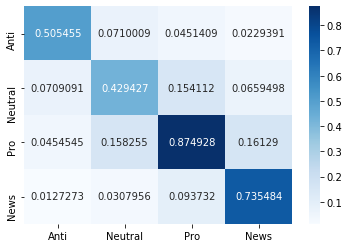

In [12]:
# ploting the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from utils import clean_text, get_onehot
classes = ['Anti','Neutral','Pro','News']

cm = confusion_matrix(Test_Y,predictions_SVM)
cm = cm/cm.astype(np.float).sum(axis=1)

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding,SpatialDropout1D, Bidirectional, GRU
from keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score
from utils import clean_text, get_onehot

data = pd.read_csv('twitter_sentiment_data.csv')
data = data.dropna(subset=['message']) # remove any empty tweets

# cleaning the raw text data
data['message'] = data['message'].apply(clean_text)

# remove duplicates from data
data = data.drop_duplicates(subset=['message'])

# isolate label and text
y = data['sentiment']
y += 1
X_data = data['message']

# splitting into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size= 0.1, random_state = 1)

# Setup model parameters
EMBEDDING_FILE = "glove.twitter.27B.200d.txt" # path to embedding file 
max_features = 20000                           # we are only interested in top 50k most frequently used words
maxlen = 150                                   # tweets longer than 150 words will be truncated otherwise padded
embed_size = 200                               # size of each vector (must match the size of the glove embedding)

# tokenize training and testing data
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_tr = tokenizer.texts_to_sequences(X_train)
X_tr = sequence.pad_sequences(X_tr, maxlen=maxlen)
X_ts = tokenizer.texts_to_sequences(X_test)
X_ts = sequence.pad_sequences(X_ts, maxlen=maxlen)

# loading the embedding file (may take some time)
embeddings_index = {}
with open(EMBEDDING_FILE,encoding='utf8') as f:
  for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

word_index = tokenizer.word_index

# prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
  if i >= max_features:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
    embedding_matrix[i] = embedding_vector
  
y_tr_one = get_onehot(y_train, 4)
y_ts_one = get_onehot(y_test, 4) 

# creating the model
gru_input = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(gru_input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(128, return_sequences=True, reset_after=True, recurrent_activation='sigmoid'))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool]) 
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
gru_output = Dense(4, activation="sigmoid")(x)
gru_model = Model(gru_input, gru_output)
gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# training parameters
epochs = 20 
batch_size = 128
patience = 4    # for early stopping
file_path="gru_final.hdf5" # where to save the best model weights

# creating checkpoint to save the model
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)
callbacks_list = [checkpoint, early] #early

# training the model
gru_model.fit(X_tr, y_tr_one, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

# loading the best weights
gru_model.load_weights(file_path)

# predicting on testing set
class_prob = gru_model.predict(X_ts)
class_pred = np.argmax(class_prob,axis=1)

# some basic metrics for accuracy
print('accuracy score: ' + str(accuracy_score(y_test,class_pred)))
classes = ['Anti','Neutral','Pro','News']

# ploting the confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,class_pred)
cm = cm/cm.astype(np.float).sum(axis=1)

df_cm = pd.DataFrame(cm, index = classes, columns = classes)
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')